# Equatorial Upperocean model vs. obs comparison

The goal of this notebook is the following:

1) serve as an example of how to post-process CESM/MOM6 output;

2) create time averages of T, S and VEL fields and compared agains observations (PHC2 and Johnson et al, 2002);

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from mom6_tools.MOM6grid import MOM6grid
from mom6_tools.m6toolbox import shiftgrid
from mom6_tools.m6plot import yzcompare, yzplot
from mom6_tools.m6toolbox import cime_xmlquery
from mom6_tools import m6toolbox
from ncar_jobqueue import NCARCluster
from dask.distributed import Client
import yaml, intake, os
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from IPython.display import display, Markdown, Latex

ERROR 1: PROJ: proj_create_from_database: Open of /glade/work/gmarques/conda-envs/mom6-tools/share/proj failed


Basemap module not found. Some regional plots may not function properly


In [2]:
# Read in the yaml file
diag_config_yml_path = "diag_config.yml"
diag_config_yml = yaml.load(open(diag_config_yml_path,'r'), Loader=yaml.Loader)

In [3]:
caseroot = diag_config_yml['Case']['CASEROOT']
casename = cime_xmlquery(caseroot, 'CASE')
DOUT_S = cime_xmlquery(caseroot, 'DOUT_S')
if DOUT_S:
  OUTDIR = cime_xmlquery(caseroot, 'DOUT_S_ROOT')+'/ocn/hist/'
else:
  OUTDIR = cime_xmlquery(caseroot, 'RUNDIR')

print('Output directory is:', OUTDIR)
print('Casename is:', casename)

Output directory is: /glade/derecho/scratch/gmarques/archive/g.e30_a03c.GJRAv4.TL319_t232_wgx3_hycom1_N75.2024.079/ocn/hist/
Casename is: g.e30_a03c.GJRAv4.TL319_t232_wgx3_hycom1_N75.2024.079


In [4]:
# The following parameters must be set accordingly
######################################################

# create an empty class object
class args:
  pass

# load avg dates
avg = diag_config_yml['Avg']

args.start_date = avg['start_date']
args.end_date = avg['end_date']
args.casename = casename
args.obs = "woa-2018-tx2_3v2-annual-all"
args.monthly = casename+diag_config_yml['Fnames']['z']
args.static = casename+diag_config_yml['Fnames']['static']
args.geom =   casename+diag_config_yml['Fnames']['geom']
args.savefigs = False
args.nw = 6 # requesting 6 workers

In [5]:
# read grid info
geom_file = OUTDIR+'/'+args.geom
if os.path.exists(geom_file):
  grd = MOM6grid(OUTDIR+'/'+args.static, geom_file, xrformat=True)
else:
  grd = MOM6grid(OUTDIR+'/'+args.static, xrformat=True)

MOM6 grid successfully loaded... 



In [6]:
parallel = False
if args.nw  > 1:
  parallel = True
  cluster = NCARCluster()
  cluster.scale(args.nw)
  client = Client(cluster)
  client

In [7]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/gmarques/High-mem/proxy/41335/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/gmarques/High-mem/proxy/41335/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.100:34243,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/gmarques/High-mem/proxy/41335/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [8]:
# Compute the climatology dataset
#dset_climo = climo.stage()
variables = ['thetao', 'so', 'uo', 'h', 'z_i']
def preprocess(ds):
    ''' Compute yearly averages and return the dataset with variables'''
    return ds[variables]

ds = xr.open_mfdataset(OUTDIR+'/'+args.monthly, \
         parallel=True, data_vars='minimal', \
         coords='minimal', compat='override', preprocess=preprocess)

In [9]:
ds

<xarray.Dataset> Size: 103GB
Dimensions:  (time: 732, z_l: 34, yh: 480, xh: 540, xq: 540, z_i: 35)
Coordinates:
  * z_i      (z_i) float64 280B 0.0 5.0 15.0 25.0 ... 5.25e+03 5.75e+03 6.25e+03
  * xq       (xq) float64 4kB -286.3 -285.7 -285.0 -284.3 ... 71.67 72.33 73.0
  * yh       (yh) float64 4kB -81.56 -81.46 -81.36 -81.26 ... 87.65 87.71 87.74
  * z_l      (z_l) float64 272B 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03
  * time     (time) object 6kB 0001-01-16 12:00:00 ... 0061-12-16 12:00:00
  * xh       (xh) float64 4kB -286.7 -286.0 -285.3 -284.7 ... 71.33 72.0 72.67
Data variables:
    thetao   (time, z_l, yh, xh) float32 26GB dask.array<chunksize=(1, 34, 480, 540), meta=np.ndarray>
    so       (time, z_l, yh, xh) float32 26GB dask.array<chunksize=(1, 34, 480, 540), meta=np.ndarray>
    uo       (time, z_l, yh, xq) float32 26GB dask.array<chunksize=(1, 34, 480, 540), meta=np.ndarray>
    h        (time, z_l, yh, xh) float32 26GB dask.array<chunksize=(1, 34, 480, 540), meta=np.ndarray>
Attributes:
    NumFilesInSet:     1
    title:             MOM6 diagnostic fields table for CESM case: g.e30_a03c...
    associated_files:  areacello: g.e30_a03c.GJRAv4.TL319_t232_wgx3_hycom1_N7...
    grid_type:         regular
    grid_tile:         N/A

In [10]:
%time ds_sel = ds.sel(time=slice(args.start_date, args.end_date)).sel(yh=slice(-10,10)).isel(z_l=slice(0,14))

CPU times: user 34.8 ms, sys: 772 μs, total: 35.5 ms
Wall time: 75.2 ms


In [11]:
# load WOA18 data
catalog = intake.open_catalog(diag_config_yml['oce_cat'])
woa18 = catalog[args.obs].to_dask()
woa18['xh'] = grd['xh']
woa18['yh'] = grd['yh']
obs_label = catalog[args.obs].metadata['prefix']+' '+str(catalog[args.obs].metadata['version'])

In [12]:
# load johnson_pmel
johnson =catalog['eq-uvts-johnson'].to_dask()
johnson

<xarray.Dataset> Size: 1MB
Dimensions:     (XLON: 10, XLONedges: 11, YLAT11_101: 91, ZDEP1_50: 50)
Coordinates:
  * XLON        (XLON) float64 80B 143.0 156.0 165.0 180.0 ... 235.0 250.0 265.0
  * XLONedges   (XLONedges) float64 88B 136.5 149.5 160.5 ... 242.5 257.5 272.5
  * YLAT11_101  (YLAT11_101) float64 728B -8.0 -7.8 -7.6 -7.4 ... 9.6 9.8 10.0
  * ZDEP1_50    (ZDEP1_50) float64 400B 5.0 15.0 25.0 35.0 ... 475.0 485.0 495.0
Data variables:
    POTEMPM     (ZDEP1_50, YLAT11_101, XLON) float32 182kB dask.array<chunksize=(50, 91, 10), meta=np.ndarray>
    SALINITYM   (ZDEP1_50, YLAT11_101, XLON) float32 182kB dask.array<chunksize=(50, 91, 10), meta=np.ndarray>
    SIGMAM      (ZDEP1_50, YLAT11_101, XLON) float32 182kB dask.array<chunksize=(50, 91, 10), meta=np.ndarray>
    UM          (ZDEP1_50, YLAT11_101, XLON) float32 182kB dask.array<chunksize=(50, 91, 10), meta=np.ndarray>
    TSPTS       (ZDEP1_50, YLAT11_101, XLON) float32 182kB dask.array<chunksize=(50, 91, 10), meta=np.ndarray>
    UPTS        (ZDEP1_50, YLAT11_101, XLON) float32 182kB dask.array<chunksize=(50, 91, 10), meta=np.ndarray>
Attributes:
    history:  FERRET V5.41    1-Oct-02

In [13]:
print('Time averaging...')
# compute annual mean and then average in time
ds_ann = m6toolbox.weighted_temporal_mean_vars(ds_sel)
thetao = ds_ann.thetao.mean('time')
so = ds_ann.so.mean('time')
uo = ds_ann.uo.mean('time')

Time averaging...


In [15]:
print('Selecting equatorial data...')
# select Equatorial region
grd_eq = grd.sel(yh=slice(-10,10))
# find point closest to eq. and select data
j = np.abs( grd_eq.geolat[:,0].values - 0. ).argmin()
temp_eq = np.ma.masked_invalid(thetao.isel(yh=j).values)
salt_eq = np.ma.masked_invalid(so.isel(yh=j).values)
u_eq    = np.ma.masked_invalid(uo.isel(yh=j).values)
#e_eq    = np.ma.masked_invalid(eta.isel(yh=j).values)
thetao_obs_eq = np.ma.masked_invalid(woa18.thetao.sel(yh=slice(-10,10)).isel(yh=j).isel(z_l=slice(0,14)).values)
salt_obs_eq = np.ma.masked_invalid(woa18.so.sel(yh=slice(-10,10)).isel(yh=j).isel(z_l=slice(0,14)).values)

Selecting equatorial data...


In [16]:
y = ds.yh.values
zz = ds.z_i[0:15].values
x = ds.xh.values
[X, Z] = np.meshgrid(x, zz)
z = 0.5 * ( Z[:-1] + Z[1:])

In [17]:
print('Saving netCDF files...')
if not os.path.isdir('ncfiles'):
      os.system('mkdir -p ncfiles')

Saving netCDF files...


In [18]:
# create dataarays and saving data
temp_eq_da = xr.DataArray(temp_eq, dims=['zl','xh'],
                          coords={'zl' : z[:,0], 'xh' : x[:]}).rename('temp_eq')

attrs = {'casename': args.casename}
m6toolbox.add_global_attrs(temp_eq_da,attrs)
temp_eq_da.to_netcdf('ncfiles/'+str(args.casename)+'_temp_eq.nc')

In [19]:
salt_eq_da = xr.DataArray(salt_eq, dims=['zl','xh'],
                       coords={'zl' : z[:,0], 'xh' : x[:]}).rename('salt_eq')
m6toolbox.add_global_attrs(salt_eq_da,attrs)
salt_eq_da.to_netcdf('ncfiles/'+str(args.casename)+'_salt_eq.nc')

In [20]:
client.close(); cluster.close()

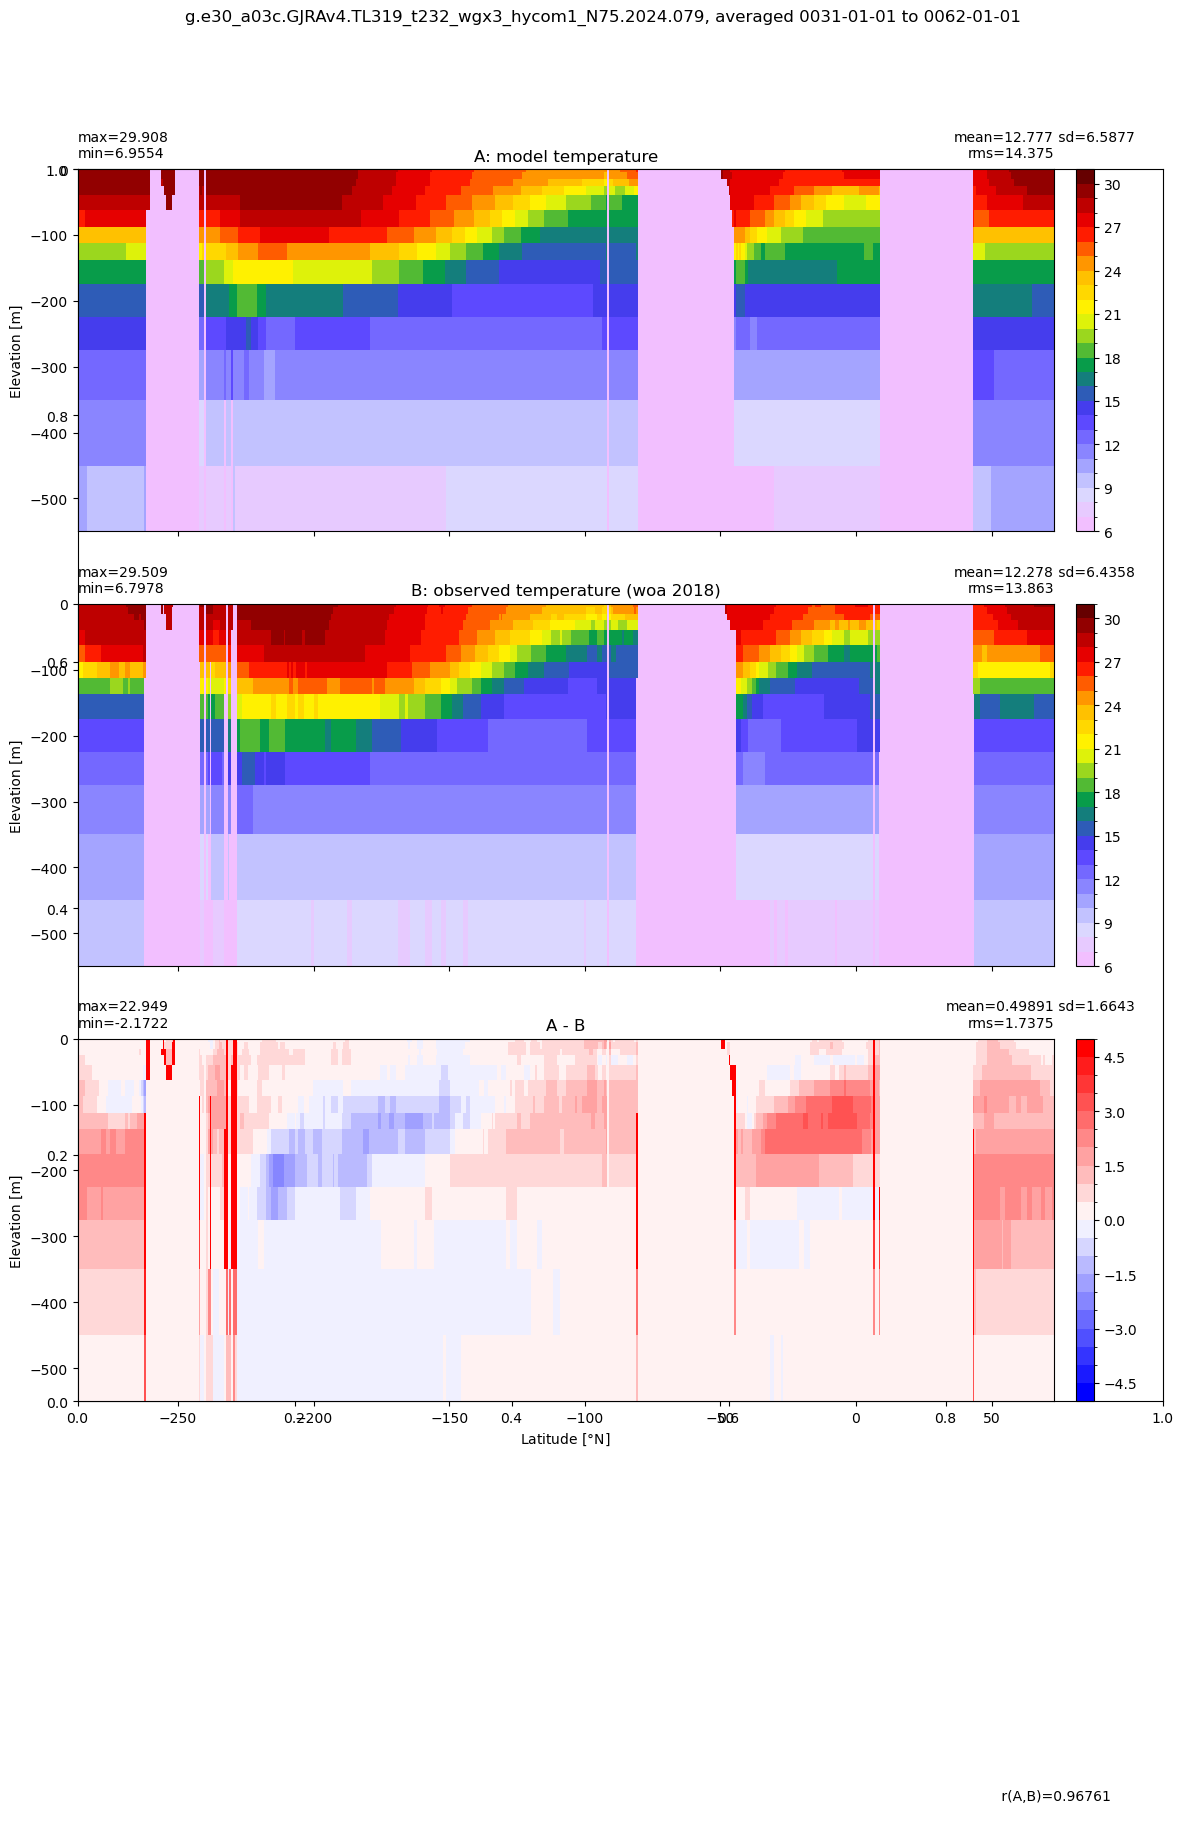

In [22]:
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14,16))
yzcompare(temp_eq , thetao_obs_eq, x, -Z,
        title1 = 'model temperature',
        title2 = 'observed temperature ({})'.format(obs_label), axis=ax,
        suptitle=casename + ', averaged '+str(args.start_date)+ ' to ' +str(args.end_date),
        extend='neither', dextend='neither', clim=(6,31.), dlim=(-5,5), dcolormap=plt.cm.bwr)

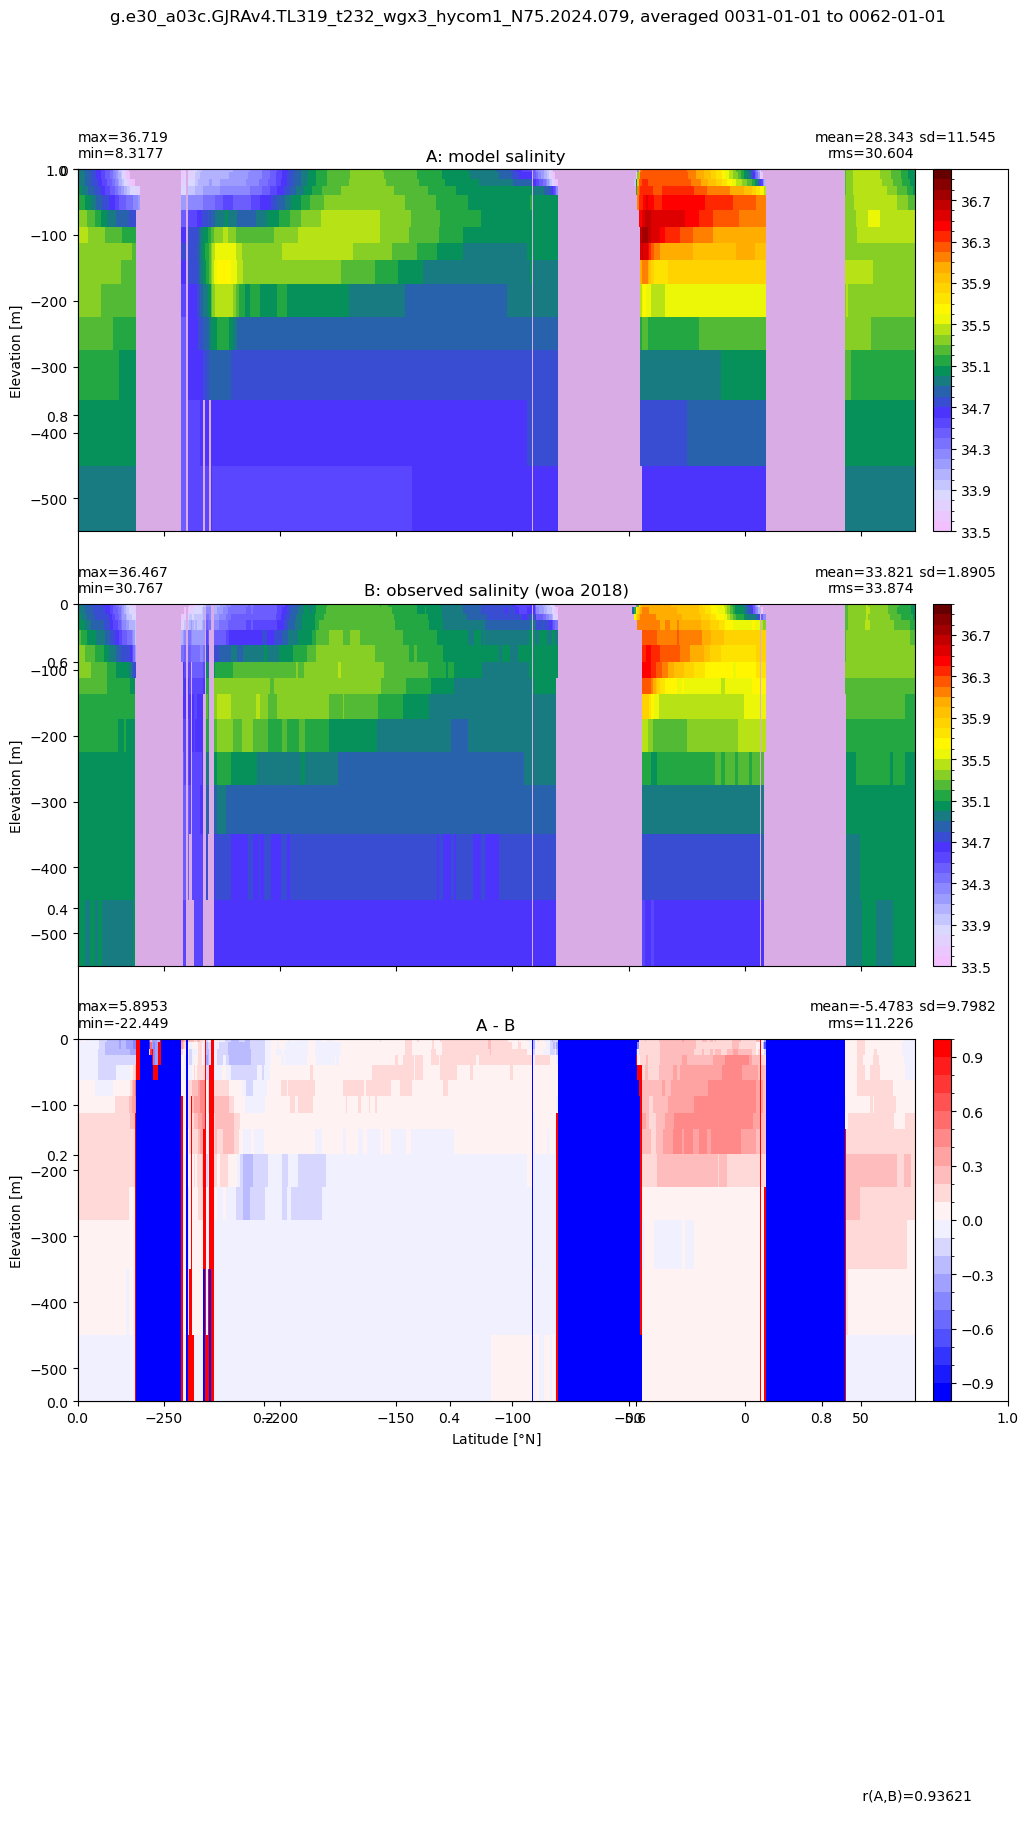

In [24]:
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,16))
yzcompare(salt_eq , salt_obs_eq, x, -Z,
        title1 = 'model salinity',
        title2 = 'observed salinity ({})'.format(obs_label), axis=ax,
        suptitle=casename + ', averaged '+str(args.start_date)+ ' to ' +str(args.end_date),
        extend='neither', dextend='neither', clim=(33.5,37.), dlim=(-1,1), dcolormap=plt.cm.bwr)

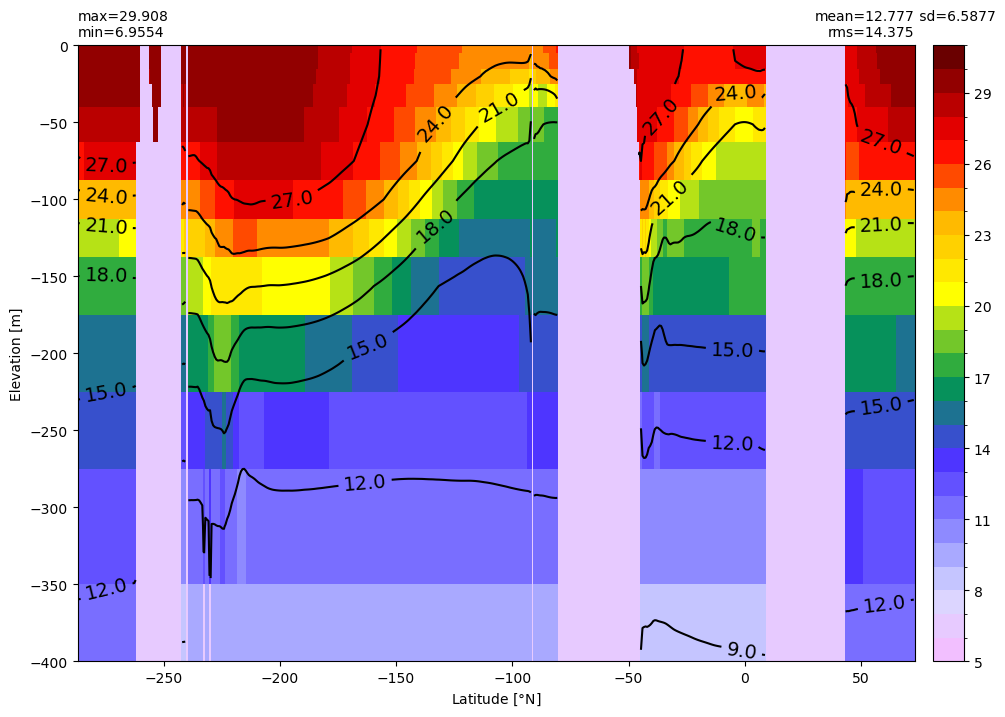

In [25]:
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,8))
yzplot(temp_eq, x, -Z, axis=ax, clim=(5,31), landcolor=[0., 0., 0.], ignore=np.nan)
cs1 = ax.contour( x + 0*z, -z, temp_eq,  colors='k',); plt.clabel(cs1,fmt='%2.1f', fontsize=14)
plt.ylim(-400,0);

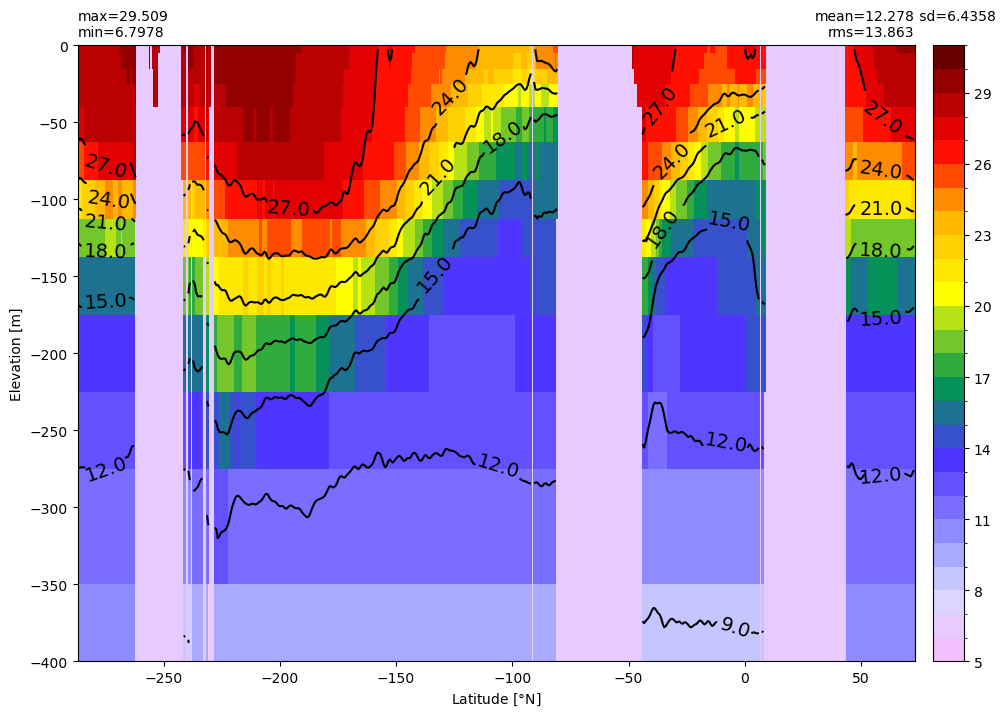

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,8))
yzplot(thetao_obs_eq, x, -Z, axis=ax, clim=(5,31))
cs1 = ax.contour( x + 0*z, -z, thetao_obs_eq,  colors='k',); plt.clabel(cs1,fmt='%2.1f', fontsize=14)
ax.set_ylim(-400,0);

In [27]:
# Shift model data to compare against obs
tmp, lonh = shiftgrid(thetao.xh[-1].values, thetao[0,0,:].values, ds.thetao.xh.values)
tmp, lonq = shiftgrid(uo.xq[-1].values, uo[0,0,:].values, uo.xq.values)

thetao['xh'].values[:] = lonh
so['xh'].values[:] = lonh
uo['xq'].values[:] = lonq

In [28]:
# y and z from obs 
y_obs = johnson.YLAT11_101.values
zz = np.arange(0,510,10)
[Y, Z_obs] = np.meshgrid(y_obs, zz)
z_obs = 0.5 * ( Z_obs[0:-1,:] + Z_obs[1:,] )

In [29]:
# y and z from model
y_model = thetao.yh.values
z = ds.z_i[0:15].values
[Y, Z_model] = np.meshgrid(y_model, z)
z_model = 0.5 * ( Z_model[0:-1,:] + Z_model[1:,:] )

In [30]:
longitudes = [143., 156., 165., 180., 190., 205., 220., 235., 250., 265.]

In [ ]:
# Temperature
for l in longitudes:
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
    dummy_model = np.ma.masked_invalid(thetao.sel(xh=l, method='nearest').values)
    dummy_obs = np.ma.masked_invalid(johnson.POTEMPM.sel(XLON=l, method='nearest').values)
    yzplot(dummy_model, y_model, -Z_model, clim=(9,29), axis=ax1, zlabel='Depth', ylabel='Latitude', title=str(dcase.casename))
    cs1 = ax1.contour( y_model + 0*z_model, -z_model, dummy_model, levels=np.arange(0,30,2), colors='k',); plt.clabel(cs1,fmt='%3.1f', fontsize=14)
    ax1.set_ylim(-400,0)
    yzplot(dummy_obs, y_obs, -Z_obs, clim=(9,29), axis=ax2, zlabel='Depth', ylabel='Latitude', title='Johnson et al (2002)')
    cs2 = ax2.contour( y_obs + 0*z_obs, -z_obs, dummy_obs, levels=np.arange(0,30,2), colors='k',); plt.clabel(cs2,fmt='%3.1f', fontsize=14)
    ax2.set_ylim(-400,0)
    plt.suptitle('Temperature [C] @ '+str(l)+ ', averaged between '+str(args.start_date)+' and '+str(args.end_date))

In [ ]:
for l in longitudes:
    # Salt
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
    dummy_model = np.ma.masked_invalid(so.sel(xh=l, method='nearest').values)
    dummy_obs = np.ma.masked_invalid(johnson.SALINITYM.sel(XLON=l, method='nearest').values)
    yzplot(dummy_model, y_model, -Z_model, clim=(32,36), axis=ax1, zlabel='Depth', ylabel='Latitude', title=str(dcase.casename))
    cs1 = ax1.contour( y_model + 0*z_model, -z_model, dummy_model, levels=np.arange(32,36,0.5), colors='k',); plt.clabel(cs1,fmt='%3.1f', fontsize=14)
    ax1.set_ylim(-400,0)
    yzplot(dummy_obs, y_obs, -Z_obs, clim=(32,36), axis=ax2, zlabel='Depth', ylabel='Latitude', title='Johnson et al (2002)')
    cs2 = ax2.contour( y_obs + 0*z_obs, -z_obs, dummy_obs, levels=np.arange(32,36,0.5), colors='k',); plt.clabel(cs2,fmt='%3.1f', fontsize=14)
    ax2.set_ylim(-400,0)
    plt.suptitle('Salinity [psu] @ '+str(l)+ ', averaged between '+str(args.start_date)+' and '+str(args.end_date))

In [ ]:
for l in longitudes:
    # uo
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
    dummy_model = np.ma.masked_invalid(uo.sel(xq=l, method='nearest').values)
    dummy_obs = np.ma.masked_invalid(johnson.UM.sel(XLON=l, method='nearest').values)
    yzplot(dummy_model, y_model, -Z_model, clim=(-1,1), axis=ax1, zlabel='Depth', ylabel='Latitude', title=str(dcase.casename))
    cs1 = ax1.contour( y_model + 0*z_model, -z_model, dummy_model, levels=np.arange(-1,1,0.1), colors='k',); plt.clabel(cs1,fmt='%3.1f', fontsize=14)
    ax1.set_ylim(-400,0)
    yzplot(dummy_obs, y_obs, -Z_obs, clim=(-1,1), axis=ax2, zlabel='Depth', ylabel='Latitude', title='Johnson et al (2002)')
    cs2 = ax2.contour( y_obs + 0*z_obs, -z_obs, dummy_obs, levels=np.arange(-1,1,0.1), colors='k',); plt.clabel(cs2,fmt='%3.1f', fontsize=14)
    ax2.set_ylim(-400,0)
    plt.suptitle('Eastward velocity [m/s] @ '+str(l)+ ', averaged between '+str(args.start_date)+' and '+str(args.end_date))

In [ ]:
x_obs = johnson.XLON.values
[X_obs, Z_obs] = np.meshgrid(x_obs, zz)
z_obs = 0.5 * ( Z_obs[:-1,:] + Z_obs[1:,:] )

In [ ]:
x_model = so.xh.values
z = ds.z_i[0:15].values
[X, Z_model] = np.meshgrid(x_model, z)
z_model = 0.5 * ( Z_model[:-1,:] + Z_model[1:,:] )

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
dummy_obs = np.ma.masked_invalid(johnson.UM.sel(YLAT11_101=0).values)
dummy_model = np.ma.masked_invalid(uo.sel(yh=0, method='nearest').values)

yzplot(dummy_model, x_model, -Z_model, clim=(-0.4,1.2), axis=ax1, landcolor=[0., 0., 0.], title=str(dcase.casename), ylabel='Longitude', yunits=r'$^o$E' )
cs1 = ax1.contour( x_model + 0*z_model, -z_model, dummy_model,  levels=np.arange(-1.2,1.2,0.1), colors='k',); plt.clabel(cs1,fmt='%2.1f', fontsize=14)
ax1.set_xlim(143,265); ax1.set_ylim(-400,0)
yzplot(dummy_obs, x_obs, -Z_obs, clim=(-0.4,1.2), axis=ax2, title='Johnson et al (2002)', ylabel='Longitude', yunits=r'$^o$E' )
cs1 = ax2.contour( x_obs + 0*z_obs, -z_obs, dummy_obs,  levels=np.arange(-1.2,1.2,0.1), colors='k',); plt.clabel(cs1,fmt='%2.1f', fontsize=14)
ax2.set_xlim(143,265); ax2.set_ylim(-400,0)
plt.suptitle('Eastward velocity [m/s] along the Equatorial Pacific, averaged between '+str(args.start_date)+' and '+str(args.end_date))